# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

## Imports

In [1]:
import os
import csv
import pickle
import numpy as np
import random
import pandas as pd
import cv2
from sklearn.utils import shuffle
import scipy.misc
import tensorflow as tf
from tensorflow.contrib.layers import flatten

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---
## Step 0: Load The Data

In [2]:
%%bash

# if dataset is missing, automatically download and unzip it
mkdir -p data
if test -n "$(find ./data -maxdepth 1 -name '*.p' -print -quit)"
then
    echo 'Dataset has already been downloaded'
else
    echo 'Downloading the dataset...'
    wget 'https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip'
    unzip traffic-signs-data.zip -d data
    rm traffic-signs-data.zip
    echo 'Done'
fi

Dataset has already been downloaded


In [3]:
# Load pickled data
training_file = 'data/train.p'
validation_file = 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

assert(len(x_train) == len(y_train))
assert(len(x_valid) == len(y_valid))
assert(len(x_test) == len(y_test))

---

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
# Number of training examples
n_train = len(x_train)

# Number of validation examples
n_validation = len(x_valid)

# Number of testing examples.
n_test = len(x_test)

# What's the shape of an traffic sign image?
image_shape = x_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

assert(n_classes == len(np.unique(y_valid)) == len(np.unique(y_test)))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

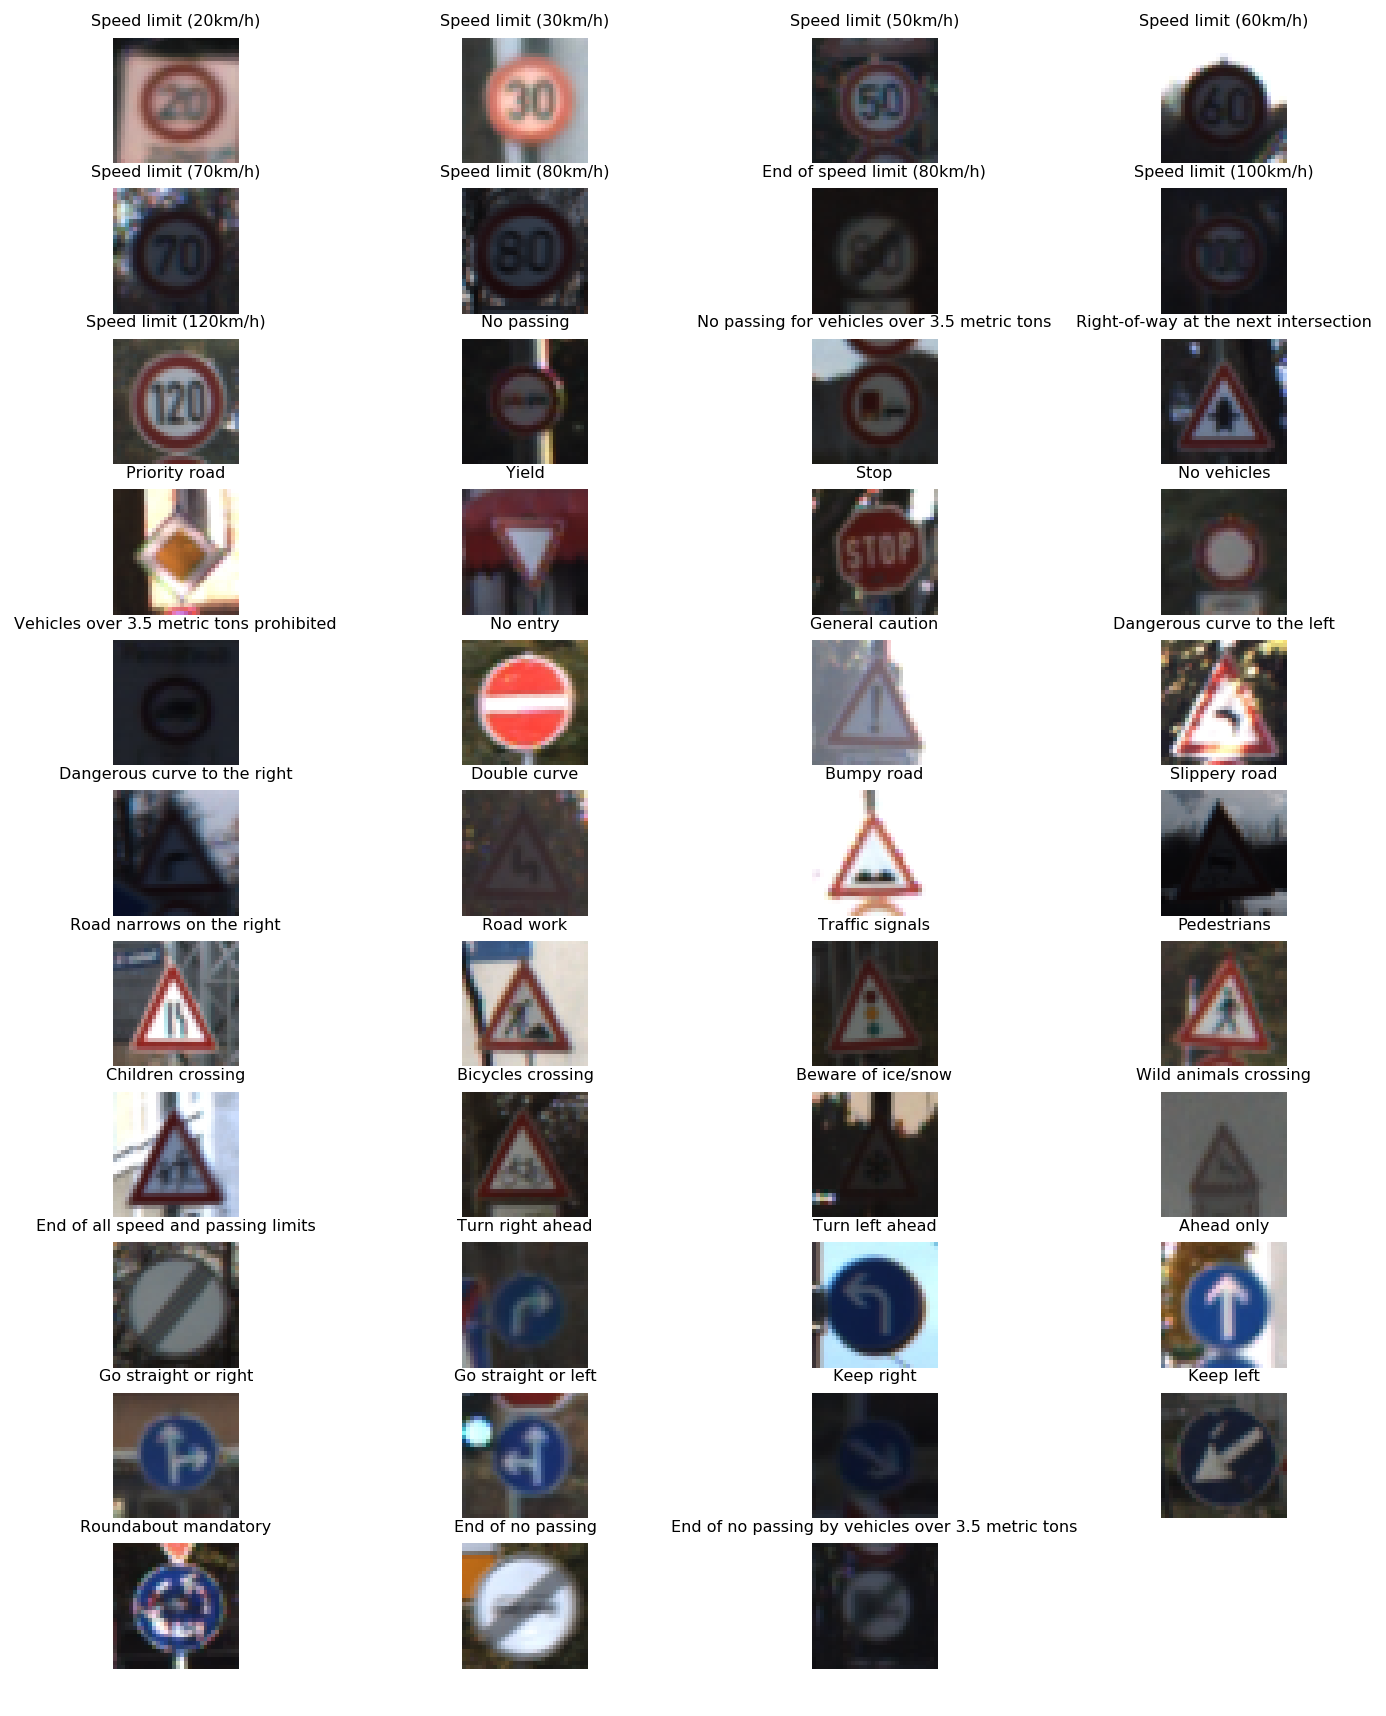

In [5]:
sn = pd.read_csv('signnames.csv')
signnames = list(sn.SignName)

def show_image(location, title, img):
    plt.subplot(*location)
    plt.title(title,fontsize=8)
    plt.axis('off')
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')

# plot random set of images for each sign class
plt.figure(figsize=(12,15))
for sign in range(n_classes):
    [index] = random.sample(list(np.where(y_train == sign)[0]),1)
    show_image((11, 4, sign+1), signnames[sign], x_train[index])

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

In [6]:
def normalize(image):
    # grayscale
    grayscale = tf.image.rgb_to_grayscale(image)
    # normalization
    normalized = (grayscale - 128.0) / 128.0
    return normalized

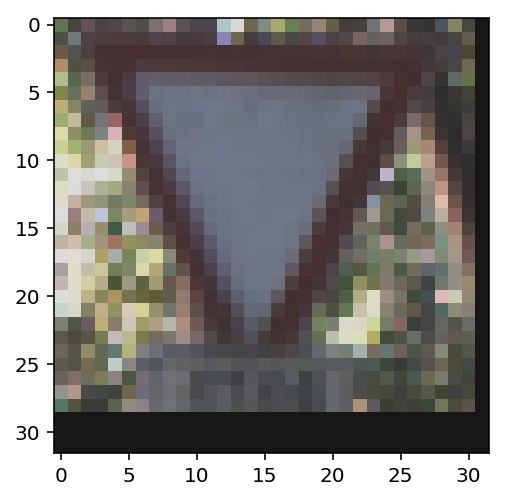

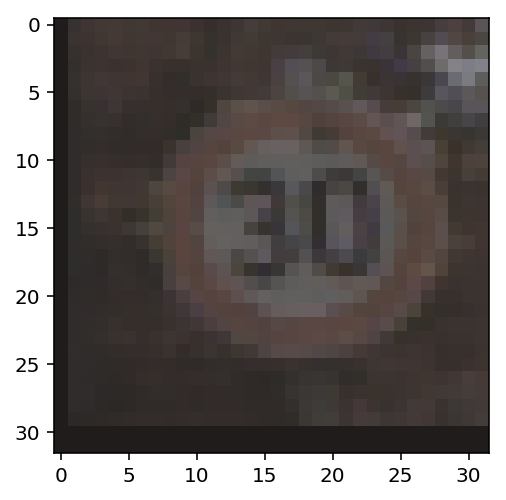

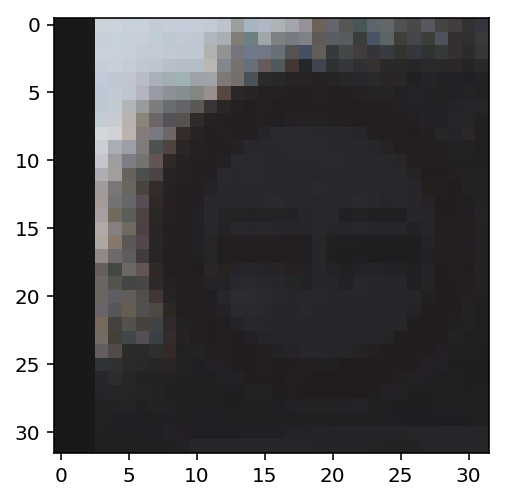

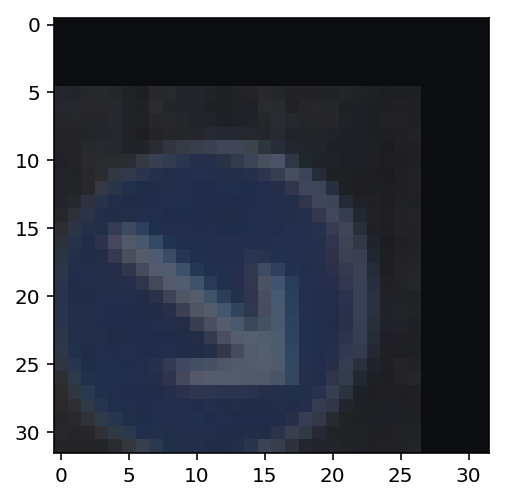

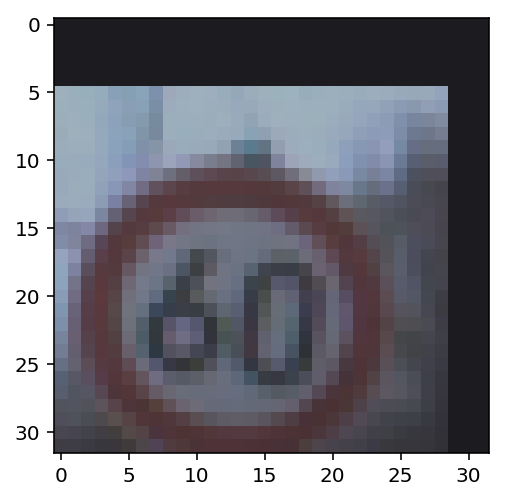

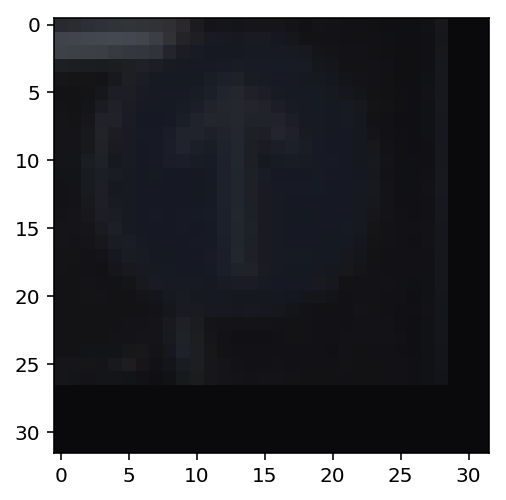

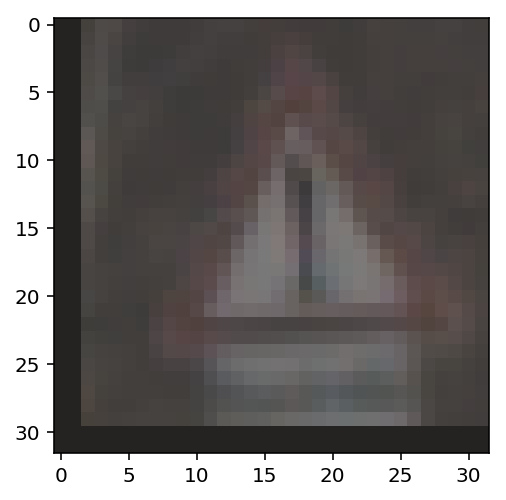

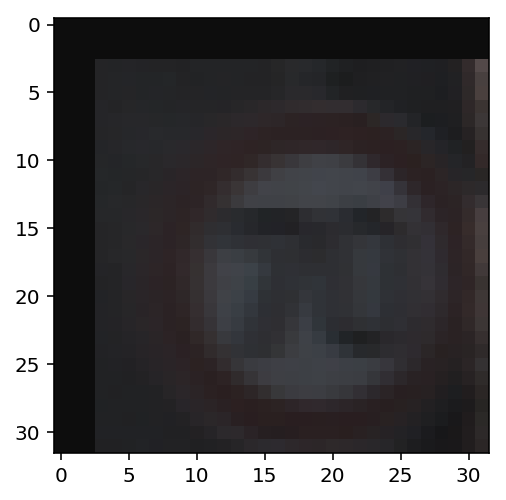

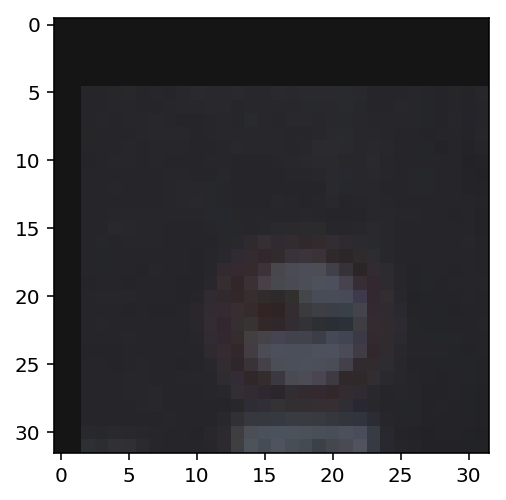

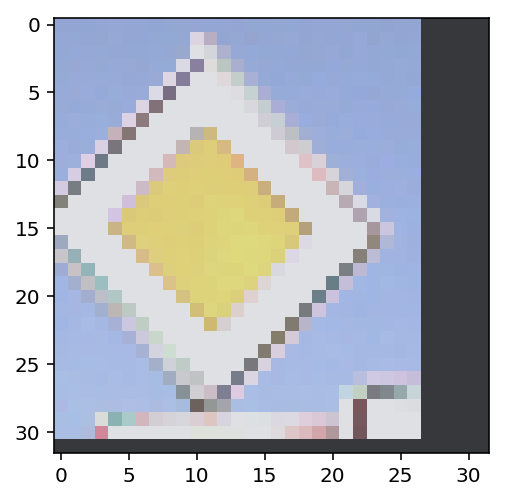

In [7]:
def augment_training_images(images):
    padding = 5
    image_shape = tf.shape(images)
    images = tf.map_fn(
        lambda img: tf.image.pad_to_bounding_box(
            img, padding, padding, image_shape[1]+2*padding, image_shape[2]+2*padding
        ), images
    )
    images = tf.map_fn(
        lambda img: tf.random_crop(img, size=image_shape[1:]), images
    )
    images = tf.map_fn(
        lambda img: tf.image.random_contrast(img, 0.5, 1.0), images
    )
    images = tf.map_fn(
        lambda img: tf.image.random_brightness(img, 0.1), images
    )
    images = tf.map_fn(
        lambda img: tf.image.random_saturation(img, 0.5, 1.0), images
    )
    return images

with tf.Session() as session:
    samples = []
    for index in random.sample(range(x_test.shape[0]), 10):
        samples.append(x_test[index])

    augmented_sample = augment_training_images(np.array(samples))
    result = session.run(augmented_sample)
    for image in result:
        plt.imshow(image)
        plt.show()


### Model Architecture

This is classic LeNet-5, but with dropouts in fully connected layers.

In [8]:
def LeNet(x, num_classes, input_depth, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x{input_depth}. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, input_depth, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1, name='conv1')

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2, name='conv2')

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = num_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, num_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(num_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

In [9]:
%%bash
mkdir -p models

In [10]:
# hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 15
BATCH_SIZE = 128
DROPOUT = 0.5

In [11]:
# placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 3), name='x')
y = tf.placeholder(tf.int32, (None), name='y')
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
augment_input = tf.placeholder(tf.bool, name='augment_input')

In [12]:
# pipeline
# augment_input_predicate = tf.logical_and(
#     augment_input, tf.less(tf.random_uniform(shape=()), 0.2)
# )
# x_maybe_augmented = tf.select(augment_input_predicate, augment_training_images(x), x)

x_norm = normalize(x)
logits = LeNet(x_norm, n_classes, 1, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

In [13]:
# evaluate
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(x_data, y_data):
    num_examples = len(x_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, augment_input: False})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return (total_accuracy/num_examples, total_loss/num_examples)

In [14]:
# train
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train_shuffled, y_train_shuffled = shuffle(x_train, y_train)
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train_shuffled[offset:end], y_train_shuffled[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT, augment_input: True})
        
        training_accuracy, training_loss = evaluate(x_train, y_train)
        validation_accuracy, validation_loss = evaluate(x_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}\tTraining Loss = {:.3f}".format(training_accuracy, training_loss))
        print("Validation Accuracy = {:.3f}\tValidation Loss = {:.3f}".format(validation_accuracy, validation_loss))
        print()
        
    saver.save(sess, './models/model')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.596	Training Loss = 1.522
Validation Accuracy = 0.534	Validation Loss = 1.675

EPOCH 2 ...
Training Accuracy = 0.802	Training Loss = 0.731
Validation Accuracy = 0.771	Validation Loss = 0.853

EPOCH 3 ...
Training Accuracy = 0.875	Training Loss = 0.468
Validation Accuracy = 0.830	Validation Loss = 0.594

EPOCH 4 ...
Training Accuracy = 0.911	Training Loss = 0.341
Validation Accuracy = 0.860	Validation Loss = 0.504

EPOCH 5 ...
Training Accuracy = 0.924	Training Loss = 0.268
Validation Accuracy = 0.886	Validation Loss = 0.398

EPOCH 6 ...
Training Accuracy = 0.945	Training Loss = 0.208
Validation Accuracy = 0.897	Validation Loss = 0.361

EPOCH 7 ...
Training Accuracy = 0.959	Training Loss = 0.165
Validation Accuracy = 0.915	Validation Loss = 0.329

EPOCH 8 ...
Training Accuracy = 0.963	Training Loss = 0.148
Validation Accuracy = 0.910	Validation Loss = 0.321

EPOCH 9 ...
Training Accuracy = 0.967	Training Loss = 0.126
Validation Accuracy = 0

In [15]:
# test the model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models'))

    test_accuracy, test_loss = evaluate(x_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Test Loss = {:.3f}".format(test_loss))

Test Accuracy = 0.925
Test Loss = 0.331


---

## Step 3: Test a Model on New Images

### Load and Output the Images

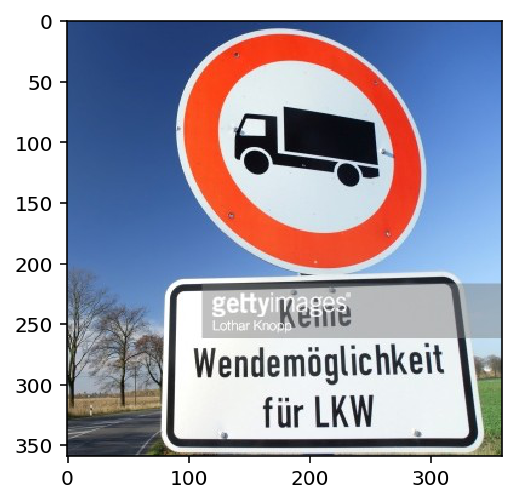

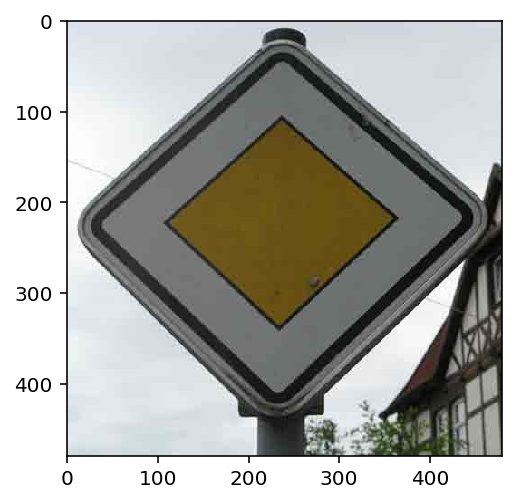

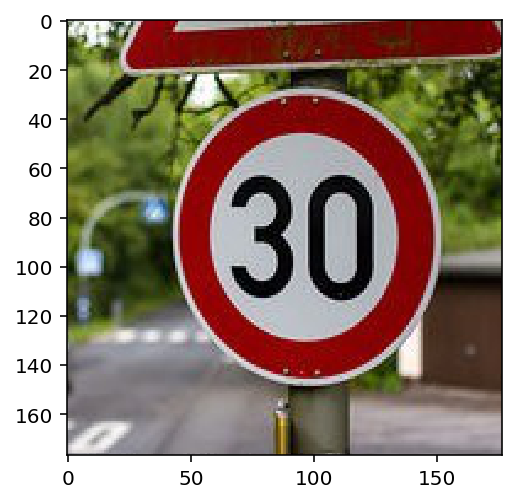

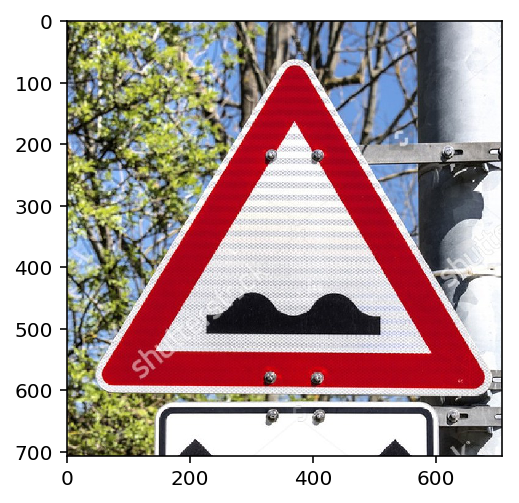

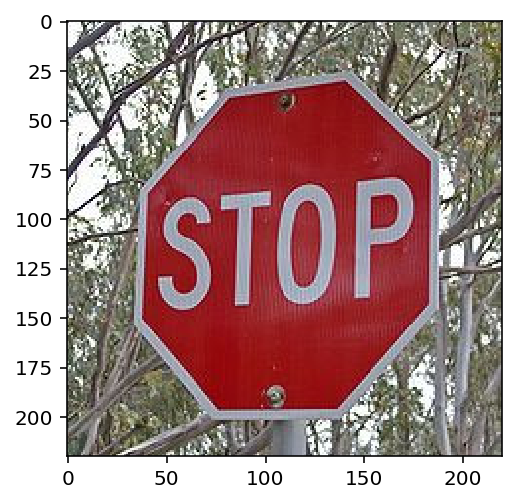

In [16]:
image_files = os.listdir('german-signs/')
image_files.sort()

# images
images = []

# normalized images
x_new = []
for image_file in image_files:
    image = mpimg.imread(os.path.join('german-signs/', image_file))
    images.append(image)
    
    plt.imshow(image)
    plt.show()
    
    resized_image = scipy.misc.imresize(image, (32, 32, 3))
    x_new.append(resized_image)

# labels
y_new = [
    10,
    12,
    1,
    22,
    14
]

### Analyze Performance

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models'))

    accuracy, _ = evaluate(x_new, y_new)
    print("Accuracy = {:.3f}".format(accuracy))

Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [18]:
def load_label_names():
    label_names = {}
    with open('./signnames.csv', newline='') as csvfile:
        reader = csv.reader(csvfile)
        for index, row in enumerate(reader):
            if index == 0:
                continue
            label_names[int(row[0])] = row[1]
    return label_names

In [19]:
def display_image_predictions(features, labels, predictions, n_predictions, n_classes):
    """
    A nice helper function to render images and top K predictions side-by-side
    (borrowed from Udacity Deep Learning Nanodegree - Project 2)
    """
    label_names = load_label_names()
    label_ids = labels

    fig, axies = plt.subplots(nrows=len(features), ncols=2, figsize=(15,15))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        
        correct_name = label_names[label_id]
        
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        pred_names = ['{}\n{:.6f}'.format(name, pred_values[index]) for index, name in enumerate(pred_names)]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        
        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

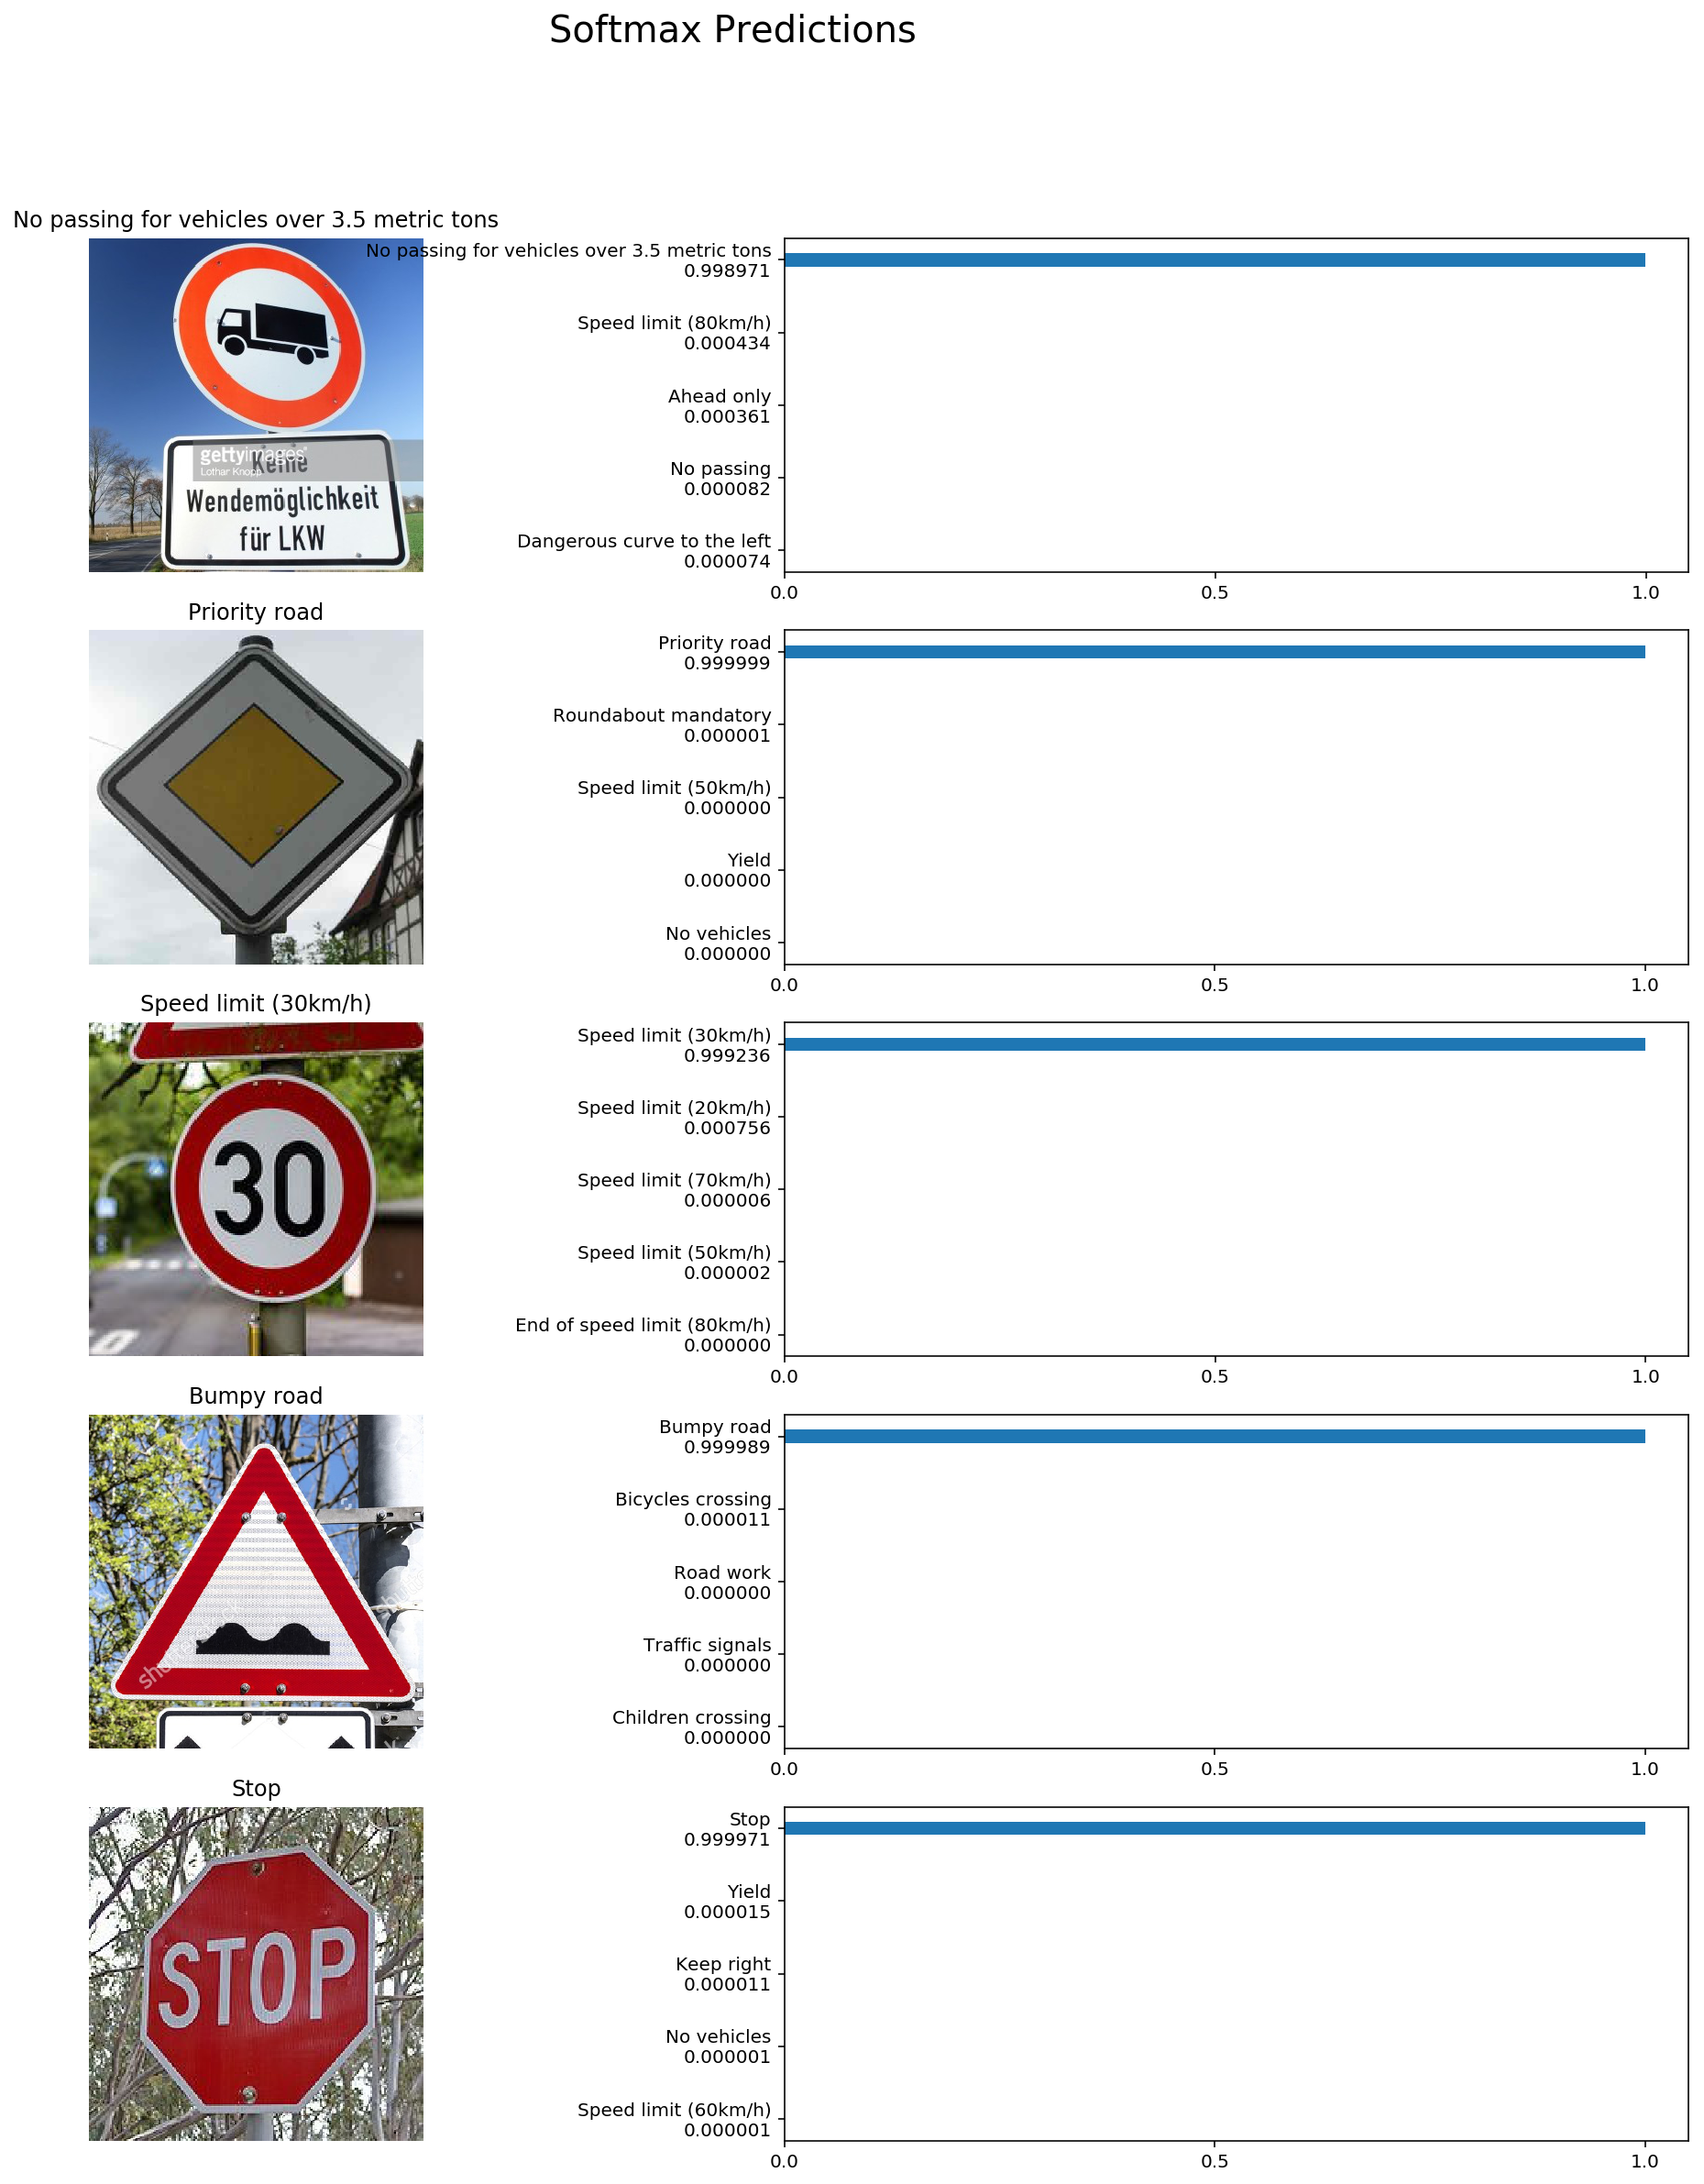

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models'))
    
    top_k = 5
    
    predictions = tf.nn.top_k(tf.nn.softmax(logits), k=top_k)
    predictions_output = sess.run(predictions, feed_dict={x: x_new, keep_prob: 1.0, augment_input: False})
    
    display_image_predictions(images, y_new, predictions_output, top_k, n_classes)

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images


In [21]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, augment_input: False})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

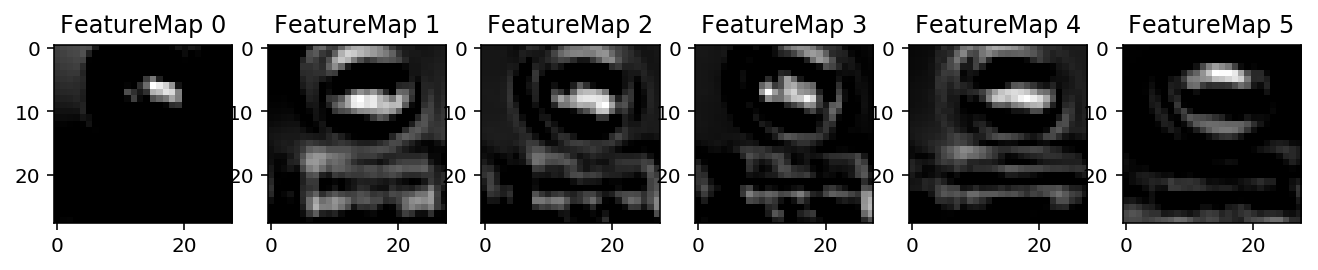

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models'))
    
    conv1 = tf.get_default_graph().get_tensor_by_name('conv1:0')
    outputFeatureMap(image_input=x_new, tf_activation=conv1)